Status: mostly complete

Conclusions: specificity is too low to pair chromatin fragments with cells of origin.
- At ~50% sequencing coverage, ~50% of species-specific beads contain mixed cell oligos - i.e., half of beads whose chromatin fragments are all human-derived have mouse cell oligos, and vice versa.

# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark

In [2]:
# Python Standard Library modules
import collections
import copy
import gzip
import itertools
import os
import re
import sys

# Basic SciPy packages
import numpy as np
import scipy
import pandas as pd

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import IPython.display

import pysam

# Custom modules
sys.path.append('../scripts')
import string_distances
import parse_barcodes
from helpers import fastq_parse

In [3]:
%watermark
%watermark --conda
%watermark --iversions

Last updated: 2024-06-29T23:23:35.756564-07:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.14.0-362.24.1.el9_3.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 128
Architecture: 64bit

conda environment: py3

seaborn   : 0.12.2
re        : 2.2.1
scipy     : 1.11.1
sys       : 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
matplotlib: 3.7.2
IPython   : 8.14.0
numpy     : 1.23.5
pandas    : 2.0.2
pysam     : 0.21.0



In [4]:
%%bash
splitcode --version

splitcode, version 0.30.0


In [5]:
DIR_PROJECT = '/central/groups/guttman/btyeh/scBarcode'
DIR_DATA = os.path.join(DIR_PROJECT, 'data', '20240625')
DIR_AUX = os.path.join(DIR_PROJECT, 'data_aux', '20240625')
DIR_PROC = os.path.join(DIR_PROJECT, 'data_proc', '20240625')
DIR_RESULTS = os.path.join(DIR_PROJECT, 'results', '20240625')

os.makedirs(DIR_AUX, exist_ok=True)
os.makedirs(DIR_PROC, exist_ok=True)
os.makedirs(DIR_RESULTS, exist_ok=True)

In [6]:
def estimate_library_complexity(count_total, count_dedup, ub=None, max_err=1e-3):
    '''
    See https://github.com/bentyeh/resources/blob/main/bioinformatics/models_genomics.md

    Generative model: Poisson sampling (i.e., with replacement) count_total reads from
    M unique molecules, such that count_dedup molecules were sampled at least once. Solve
    for M.
    '''
    if ub is None:
        ub = count_total*1e5
    res = scipy.optimize.minimize_scalar(
      fun=lambda M: (M * (1 - np.exp(-count_total/M)) - count_dedup)**2,
      bracket=(count_dedup, ub)
    )
    assert res.fun < max_err
    return res.x

def estimate_library_complexity2(count_total, count_mean, ub=None, max_err=1e-3):
    '''
    See https://github.com/bentyeh/resources/blob/main/bioinformatics/models_genomics.md

    Generative model: Poisson sampling (i.e., with replacement) count_total reads from
    M unique molecules, yielding mean observed counts count_mean. Solve for M.
    '''
    ub = ub if ub is not None else count_total*1e5
    res = scipy.optimize.minimize_scalar(
      fun=lambda M: ((count_total / M) / (1 - np.exp(-count_total / M)) - count_mean)**2,
      bracket=(count_total / count_mean, ub)
    )
    assert res.fun < max_err
    return res.x

In [7]:
# from https://docs.python.org/3/library/itertools.html
def grouper(iterable, n, *, incomplete='fill', fillvalue=None):
    "Collect data into non-overlapping fixed-length chunks or blocks."
    # grouper('ABCDEFG', 3, fillvalue='x') → ABC DEF Gxx
    # grouper('ABCDEFG', 3, incomplete='strict') → ABC DEF ValueError
    # grouper('ABCDEFG', 3, incomplete='ignore') → ABC DEF
    iterators = [iter(iterable)] * n
    match incomplete:
        case 'fill':
            return zip_longest(*iterators, fillvalue=fillvalue)
        case 'strict':
            return zip(*iterators, strict=True)
        case 'ignore':
            return zip(*iterators)
        case _:
            raise ValueError('Expected fill, strict, or ignore')

## Build combined human-mouse genome index

Download all FASTA files (1 file per chromosome) for human and mouse genomes. Rename human chromosomes from "chr*" to "h_chr*" and mouse chromosomes from "chr*" to "m_chr*"

In [8]:
%%bash
PATH_SCRATCH='/central/scratch/btyeh/hg38'
PATH_INDEX='/central/scratch/btyeh/index_hg38_mm10'
if [ ! -f "$PATH_INDEX"/hg38_mm10.rev.1.bt2l ] && [ ! -f "$PATH_SCRATCH"/h_chr1.fa ]; then
    mkdir -p "$PATH_SCRATCH"
    wget -nc -q -O - https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.chromFa.tar.gz |
        tar -xz -C "$PATH_SCRATCH"
    mv "$PATH_SCRATCH"/chroms/*.fa "$PATH_SCRATCH"
    
    # remove alternate loci sequences
    rm -r "$PATH_SCRATCH"/chroms "$PATH_SCRATCH"/*_alt.fa
    
    cd "$PATH_SCRATCH"
    for file in chr*.fa; do
        new_file="h_${file}"
        sed -e 's/^>chr/>h_chr/' "$file" > "$new_file"
        rm "$file"
    done
fi

In [9]:
%%bash
PATH_SCRATCH='/central/scratch/btyeh/mm10'
PATH_INDEX='/central/scratch/btyeh/index_hg38_mm10'
if [ ! -f "$PATH_INDEX"/hg38_mm10.rev.1.bt2l ] && [ ! -f "$PATH_SCRATCH"/m_chr1.fa ]; then
    mkdir -p "$PATH_SCRATCH"
    wget -nc -q -O - https://hgdownload.soe.ucsc.edu/goldenPath/mm10/bigZips/chromFa.tar.gz |
        tar -xz -C "$PATH_SCRATCH"
    
    cd "$PATH_SCRATCH"
    for file in chr*.fa; do
        new_file="m_${file}"
        sed -e 's/^>chr/>m_chr/' "$file" > "$new_file"
        rm "$file"
    done
fi

Build combined genome index

In [10]:
%%bash -s {DIR_PROJECT}
DIR_PROJECT="$1"

PATH_SBATCH="${DIR_PROJECT}/scripts/20240625/build_index.sbatch"
PATH_INDEX='/central/scratch/btyeh/index_hg38_mm10'

if [ ! -f "$PATH_INDEX"/hg38_mm10.rev.1.bt2l ]; then
    sbatch --output="$PATH_INDEX"/slurm.out --error="$PATH_INDEX"/slurm.err "$PATH_SBATCH"
fi

### Create IGV Genome JSON file

Concatenate all reference chromosome FASTA files and build a FASTA index

In [11]:
%%bash
PATH_SCRATCH='/central/scratch/btyeh'
PATH_INDEX="${PATH_SCRATCH}/index_hg38_mm10"

if [ ! -f "$PATH_INDEX"/hg38_mm10.fa.fai ]; then
    source ~/.bashrc
    conda activate chipdip
    
    cat "$PATH_SCRATCH"/hg38/*.fa "$PATH_SCRATCH"/mm10/*.fa > "$PATH_INDEX"/hg38_mm10.fa
    samtools faidx "$PATH_INDEX"/hg38_mm10.fa
fi

Download GENCODE annotations

In [12]:
%%bash
set -e

PATH_SCRATCH='/central/scratch/btyeh'
PATH_ANNOT="$PATH_SCRATCH"/annot

if [ ! -f "$PATH_ANNOT"/hg38_mm10.gtf.gz.tbi ]; then
    source ~/.bashrc
    conda activate chipdip
    mkdir -p "$PATH_ANNOT"
    
    # download human GENCODE GTF and rename chromosomes
    wget -q -O - https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_46/gencode.v46.basic.annotation.gtf.gz |
        unpigz -p 4 -c |
        sort -k 1,1V -k 4,4V -k 5,5V |
        sed -E -e 's/^chr/h_chr/' > "$PATH_ANNOT"/hg38.gtf
    
    # download mouse GENCODE GTF and rename chromosomes
    wget -q -O - https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gtf.gz |
        unpigz -p 4 -c |
        sort -k 1,1V -k 4,4V -k 5,5V |
        sed -E -e 's/^chr/m_chr/' > "$PATH_ANNOT"/mm10.gtf
    
    # concatenate human and mouse genome GTFs
    cat "$PATH_ANNOT"/hg38.gtf "$PATH_ANNOT"/mm10.gtf |
        bgzip --threads 4 -c /dev/stdin > "$PATH_ANNOT"/hg38_mm10.gtf.gz
    
    rm "$PATH_ANNOT"/hg38.gtf "$PATH_ANNOT"/mm10.gtf
    
    # index the combined GTF
    tabix -f "$PATH_ANNOT"/hg38_mm10.gtf.gz
fi

# FastQC

In [13]:
%%bash -s {DIR_DATA} {DIR_PROC}
DIR_DATA="$1"
DIR_PROC="$2"
DIR_FASTQC_OUT="${DIR_PROC}/fastqc"
if [ ! -d "$DIR_FASTQC_OUT" ]; then
    mkdir "${DIR_PROC}/fastqc"
    cd "$DIR_DATA"
    source ~/.bashrc
    conda activate chipdip
    fastqc *.fastq.gz -t 20 -q -o "$DIR_FASTQC_OUT"
fi

application/gzip
application/gzip


# Pipeline

1. Identify and trim bead barcode for all reads (add barcode to read name). Discard reads without a complete bead barcode.
2. Split cell oligos from chromatin. Discard reads that do not match either.
   - Trim DPM from Read 1 of chromatin reads

Cell oligo processing
- ✅ Identify cell barcode + UMI (add barcode and UMI as SAM tags)
- ✅ Deduplicate by cell barcode, bead barcode, and UMI

Chromatin processing
- ✅ Check that DPM sequence on Read 1 and Read 2 match
- ✅ Paired-end alignment to human-mouse mixed genome
- ✅ Deduplicate by alignment position and bead barcode

## Identify bead barcode

In [14]:
path_splitcode_bead_barcode = os.path.join(DIR_AUX, 'splitcode_config-bead_barcode.tsv')

In [15]:
%%bash -s {DIR_DATA} {DIR_PROC} {path_splitcode_bead_barcode}
DIR_DATA="$1"
DIR_PROC="$2"
PATH_CONFIG="$3"

PATH_R1="$DIR_DATA/CTCF_scChIP-seq_1pct_aliquot3_R1.fastq.gz"
PATH_R2="$DIR_DATA/CTCF_scChIP-seq_1pct_aliquot3_R2.fastq.gz"
PATH_MAPPING="$DIR_PROC/mapping_bead-barcode.tsv"
PATH_SUMMARY="$DIR_PROC/summary_bead-barcode.json"
PATH_OUT1="$DIR_PROC/R1_bead-barcode.fastq.gz"
PATH_OUT2="$DIR_PROC/R2_bead-barcode.fastq.gz"

splitcode -c "$PATH_CONFIG" \
    --nFastqs=2 --com-names --assign --no-outb -t 8 \
    --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" --output="$PATH_OUT1","$PATH_OUT2" \
    "$PATH_R1" "$PATH_R2"

gzip -f "$PATH_MAPPING"

* Forcing --gzip because all output file names end in .gz
* Using a list of 289 tags (vector size: 289; map size: 110,903; num elements in map: 113,119)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data/20240625/CTCF_scChIP-seq_1pct_aliquot3_R1.fastq.gz
                         /central/groups/guttman/btyeh/scBarcode/data/20240625/CTCF_scChIP-seq_1pct_aliquot3_R2.fastq.gz
* processing the reads ...
done 
* processed 3,307,406 reads, 1,190,856 reads were assigned


Modify read names so that there is no whitespace between the read name and bead barcode.

In [16]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"

PATH_OUT1="$DIR_PROC/R1_bead-barcode.fastq.gz"
PATH_OUT2="$DIR_PROC/R2_bead-barcode.fastq.gz"
PATH_TMP="$DIR_PROC/tmp.fastq.gz"

zcat "$PATH_OUT1" | sed -e 's/ BI:i:/::bead=/' | gzip > "$PATH_TMP"
mv "$PATH_TMP" "$PATH_OUT1"

zcat "$PATH_OUT2" | sed -e 's/ BI:i:/::bead=/' | gzip > "$PATH_TMP"
mv "$PATH_TMP" "$PATH_OUT2"

Parse mapping into pandas DataFrame

In [17]:
regex_bead_barcode = (
    'NYStgBot_(?P<Y>\d+),'
    'OddBot_(?P<Odd3>\d+),'
    'EvenBot_(?P<Even2>\d+),'
    'OddBot_(?P<Odd2>\d+),'
    'EvenBot_(?P<Even>\d+),'
    'OddBot_(?P<Odd>\d+),'
    'DPMBot6_(?P<DPM>\d+)'
)
df_bead_barcodes = pd.read_csv(
    os.path.join(DIR_PROC, 'mapping_bead-barcode.tsv.gz'),
    sep='\t',
    names=['final_barcode', 'barcode', 'count'],
    dtype={'count': int}
)
df_bead_barcodes = pd.concat(
    (
        df_bead_barcodes.drop(columns=['final_barcode', 'barcode']),
        df_bead_barcodes['barcode'].str.extract(regex_bead_barcode).astype(np.uint8)
    ),
    axis=1
)

## Split cell oligos and chromatin

In [18]:
path_splitcode_split_cell_oligo_chromatin = os.path.join(DIR_AUX, 'splitcode_config-split_cell_oligo_chromatin.tsv')
path_keep_grp = os.path.join(DIR_AUX, 'keep_group-split_cell_oligo_chromatin.txt')

In [19]:
%%bash -s {DIR_PROC} {path_splitcode_split_cell_oligo_chromatin} {path_keep_grp}
DIR_PROC="$1"
PATH_CONFIG="$2"
PATH_KEEP_GRP="$3"

PATH_R1="$DIR_PROC/R1_bead-barcode.fastq.gz"
PATH_R2="$DIR_PROC/R2_bead-barcode.fastq.gz"

# change working directory to DIR_PROC so that the split files are generated in that directory
cd "$DIR_PROC"

splitcode -c "$PATH_CONFIG" \
    --nFastqs=2 --assign --no-outb -t 8 --mod-names --keep-grp="$PATH_KEEP_GRP" --keep-r1-r2 --gzip --no-output \
    --mapping=/dev/null \
    "$PATH_R1" "$PATH_R2"

* Using a list of 133 tags (vector size: 133; map size: 197; num elements in map: 197)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data_proc/20240625/R1_bead-barcode.fastq.gz
                         /central/groups/guttman/btyeh/scBarcode/data_proc/20240625/R2_bead-barcode.fastq.gz
* processing the reads ...
done 
* processed 1,190,856 reads, 1,099,693 reads were assigned


## Chromatin read processing

Discard genomic reads with unmatched DPM sequence on Read 1 and Read 2, since we cannot be sure which bead they correspond to.

In [20]:
path_genomic_R1 = os.path.join(DIR_PROC, 'genomic_R1.fastq.gz')
path_tmp_R1 = os.path.join(DIR_PROC, 'tmp_R1.fastq.gz')

path_genomic_R2 = os.path.join(DIR_PROC, 'genomic_R2.fastq.gz')
path_tmp_R2 = os.path.join(DIR_PROC, 'tmp_R2.fastq.gz')

regex_bead = re.compile(r'bead=(\d+):')
regex_DPM = re.compile('\[DPMBot6_(\d+)\]')

bead_to_DPM = df_bead_barcodes['DPM'].to_dict()
count_mismatch = 0

with gzip.open(path_genomic_R1, 'rt') as f1, \
     gzip.open(path_genomic_R2, 'rt') as f2, \
     gzip.open(path_tmp_R1, 'wt') as o1, \
     gzip.open(path_tmp_R2, 'wt') as o2:
    for i, ((name1, seq1, thrd1, qual1), (name2, seq2, thrd2, qual2)) in tqdm(enumerate(zip(fastq_parse(f1), fastq_parse(f2)))):
        bead = int(regex_bead.search(name1).groups()[0])
        bead_DPM = int(bead_to_DPM[bead])
        chromatin_DPM = int(regex_DPM.search(name1).groups()[0])
        if bead_DPM == chromatin_DPM:
            o1.write(f'{name1}\n{seq1}\n{thrd1}\n{qual1}\n')
            o2.write(f'{name2}\n{seq2}\n{thrd2}\n{qual2}\n')
        else:
            count_mismatch += 1

os.replace(path_tmp_R1, path_genomic_R1)
os.replace(path_tmp_R2, path_genomic_R2)

print(f'Number of reads with mismatched DPM on read 1 and read 2: {count_mismatch} / {i} = {count_mismatch / i:.3%}')

0it [00:00, ?it/s]

Number of reads with mismatched DPM on read 1 and read 2: 1052 / 1016694 = 0.103%


Trim sequencing adapters

In [21]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"
DIR_TRIMMED="${DIR_PROC}/trimmed"
mkdir -p "$DIR_TRIMMED"

PATH_R1="${DIR_PROC}/genomic_R1.fastq.gz"
PATH_R2="${DIR_PROC}/genomic_R2.fastq.gz"
PATH_LOG="${DIR_TRIMMED}/trim_galore.log"

source ~/.bashrc
conda activate chipdip

trim_galore \
  --paired \
  --gzip \
  --cores 2 \
  --quality 20 \
  -o "$DIR_TRIMMED" \
  "$PATH_R1" "$PATH_R2" &> "$PATH_LOG"

Paired-end alignment to combined human-mouse genome

In [22]:
%%bash -s {DIR_PROJECT} {DIR_PROC}
DIR_PROJECT="$1"
DIR_PROC="$2"
PATH_SBATCH="${DIR_PROJECT}/scripts/20240625/align.sbatch"
sbatch --output="$DIR_PROC"/slurm_align.out --error="$DIR_PROC"/slurm_align.err "$PATH_SBATCH"

Submitted batch job 42361521


Filter aligned reads
- required flags: 3
  - 0x1: read paired
  - 0x2: read mapped in proper pair
- exclude flags (any): 2828
  - read unmapped: 0x4
  - mate unmapped: 0x8
  - secondary alignment: 0x100
  - not passing filters, such as platform/vendor quality controls: 0x200 
  - supplementary (chimeric) alignment: 0x800
- mapping quality: at least 20 (corresponding to 1% probability that mapping position is wrong)

In [23]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"
source ~/.bashrc
conda activate chipdip
samtools view -h -b -q 20 -f 3 -F 2828 "${DIR_PROC}/genomic.bam" |
    samtools sort -@ 4 -o "${DIR_PROC}/genomic_filtered.sorted.bam"
samtools index -@ 4 "${DIR_PROC}/genomic_filtered.sorted.bam" # index for loading into IGV

[bam_sort_core] merging from 0 files and 4 in-memory blocks...


Create name-sorted BAM file for easy read-pair identification

In [24]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"
source ~/.bashrc
conda activate chipdip
samtools sort -@ 4 -n "${DIR_PROC}/genomic_filtered.sorted.bam" > "${DIR_PROC}/genomic_filtered.name_sorted.bam"

[bam_sort_core] merging from 0 files and 4 in-memory blocks...


### Convert read pairs to single entries of (bead, chr, start, end)

At this point, all read pairs now have one of the following pairs of flags:
- 99 (R1 sense) + 147 (R2 antisense)
- 83 (R1 antisense) + 163 (R2 sense)

Notes about `pysam.AlignedSegment` (determined empirically when [documentation](https://pysam.readthedocs.io/en/latest/api.html#pysam.AlignedSegment) is lacking)
- For any mapped read, `reference_end` >= `reference_start`
- `template_length` is obtained from column 9 in the underlying SAM/BAM file.
  - From the SAM format specification: "The `TLEN` field is positive for the leftmost segment of the template, negative for the rightmost"

Here, I essentially try to create a BED3 file entry for each read pair.

In [25]:
read_pairs = []
with pysam.AlignmentFile(os.path.join(DIR_PROC, 'genomic_filtered.name_sorted.bam'), 'rb') as f:
    for read1, read2 in tqdm(grouper(f.fetch(until_eof=True), 2, incomplete='strict')):
        assert read1.qname == read2.qname
        assert read1.reference_name == read2.reference_name
        assert read1.reference_end >= read1.reference_start
        assert read2.reference_end >= read2.reference_start
        assert read1.template_length == -read2.template_length
        bead = int(regex_bead.search(read1.qname).groups()[0])
        if read1.is_reverse:
            assert read2.is_forward
            entry = (bead, read1.reference_name, read2.reference_start, read1.reference_end - 1)
        else:
            assert read1.is_forward and read2.is_reverse
            entry = (bead, read1.reference_name, read1.reference_start, read2.reference_end - 1)
        assert entry[3] >= entry[2]
        assert entry[3] - entry[2] + 1 == abs(read1.template_length)
        read_pairs.append(entry)

[E::idx_find_and_load] Could not retrieve index file for '/central/groups/guttman/btyeh/scBarcode/data_proc/20240625/genomic_filtered.name_sorted.bam'


0it [00:00, ?it/s]

### Deduplicate chromatin read pairs and estimate complexity

Options of deduplicating chromatin read pairs
1. Least conservative (i.e., retaining the most reads): only count as duplicates read pairs with identical bead, chr, start, and end.
2. Count as duplicates read pairs with identical bead, chr, and start.
3. Count as duplicates read pairs with identical bead, chr, and start.
4. Most conservative (i.e., retaining the fewest reads): any read pair with identical bead, chr, and either start or end.
   - This deduplicates over sets of reads, not just pairs of reads. Two reads with different start and end positions can now count as duplicates if a third read shares the start of the first read and the end of the second read.

Note that each DNA fragment yields 2 unique amplicons due to ligating DPMs on both ends of the fragment - one where read 1 yields the sense sequence, and one where read 1 yields the antisense sequence. This raises some potential concerns:
1. Deduplication. We want to treat all reads arising from the same DNA fragment as duplicates, regardless of orientation. By essentially creating a BED3 entry for each read pair, we already remove strandedness information. Consequently, any of the deduplication options proposed above will treat as duplicates 2 read pairs arising from the same DNA fragment but with different orientations.
2. Complexity. By counting duplicates per concern 1 above, this means that the complexity that we estimate is of the true number of DNA fragments, which is what we want to know.
3. Ligation and sequencing errors. The DPM ligations on either end of the DNA fragment may have have slightly different insertions/deletions, leading to slightly offset start and end positions. Consequently, deduplicating by both start *or* end positions would better account for ligation and sequencing errors.

In [26]:
n_chromatin_nodedup = len(read_pairs)
n_chromatin_dedup_start_and_end = len(set(read_pairs))
n_chromatin_dedup_start = len(set(entry[0:3] for entry in read_pairs))
n_chromatin_dedup_end = len(set((entry[0], entry[1], entry[3]) for entry in read_pairs))

read_pairs_start_or_end = collections.defaultdict(list)
for bead, chrom, start, end in read_pairs:
    read_pairs_start_or_end[(bead, chrom)].append({'start': set((start,)), 'end': set((end,))})
for (bead, chrom), deduped_pairs in read_pairs_start_or_end.items():
    for i in range(len(deduped_pairs) - 1):
        pair_i = deduped_pairs[i]
        for j in range(i+1, len(deduped_pairs)):
            pair_j = deduped_pairs[j]
            if (len(pair_i['start'] & pair_j['start']) > 0) or (len(pair_i['end'] & pair_j['end']) > 0):
                # merge start and end positions of pair j into pair i
                pair_i['start'] |= pair_j['start']
                pair_i['end'] |= pair_j['end']
                deduped_pairs[i] = pair_i
                deduped_pairs[j] = {'start': set(), 'end': set()}
    read_pairs_start_or_end[(bead, chrom)] = [pair for pair in deduped_pairs if len(pair['start']) > 0]
# validate this 4th method of deduplication
for (bead, chrom), deduped_pairs in read_pairs_start_or_end.items():
    for i in range(len(deduped_pairs) - 1):
        pair_i = deduped_pairs[i]
        assert len(pair_i['start']) > 0 and len(pair_i['end']) > 0
        for j in range(i+1, len(deduped_pairs)):
            pair_j = deduped_pairs[j]
            assert (len(pair_i['start'] & pair_j['start']) == 0) and (len(pair_i['end'] & pair_j['end']) == 0)
    assert len(deduped_pairs[-1]['start']) > 0 and len(deduped_pairs[-1]['end']) > 0

n_chromatin_dedup_start_or_end = sum(map(len, read_pairs_start_or_end.values()))

In [27]:
print('Properly aligned chromatin read pairs (prior to deduplication)', n_chromatin_nodedup)
print('Deduplicated by start and end positions:', n_chromatin_dedup_start_and_end)
print('Deduplicated by start position only:', n_chromatin_dedup_start)
print('Deduplicated by end position only:', n_chromatin_dedup_end)
print('Deduplicated by start or end positions:', n_chromatin_dedup_start_or_end)

Properly aligned chromatin read pairs (prior to deduplication) 765162
Deduplicated by start and end positions: 564565
Deduplicated by start position only: 563886
Deduplicated by end position only: 563901
Deduplicated by start or end positions: 563222


Complexity estimates

In [28]:
complexity_chromatin_high = estimate_library_complexity(n_chromatin_nodedup, n_chromatin_dedup_start_and_end)
complexity_chromatin_low = estimate_library_complexity(n_chromatin_nodedup, n_chromatin_dedup_start_or_end)
print('Complexity estimates (conservative, liberal): ({:.0f}, {:.0f})'.format(complexity_chromatin_low, complexity_chromatin_high))

Complexity estimates (conservative, liberal): (1181423, 1191231)


Estimate additional reads required to obtain saturation. For simplicity, I use deduplication by start and end positions in this calculation.

In [29]:
df_chromatin = (
    pd.DataFrame(read_pairs, columns=['bead', 'chr', 'start', 'end'])
    .groupby(['bead', 'chr', 'start', 'end'])
    .size()
    .rename('count')
    .reset_index()
)
df_chromatin['count'].to_csv(os.path.join(DIR_PROC, 'chromatin_counts.txt'), index=False, header=False)

In [30]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"

source ~/.bashrc
conda activate genomics

PATH_CHROMATIN_COUNTS="${DIR_PROC}/chromatin_counts.txt"
PATH_CHROMATIN_COMPLEXITY_CURVE="${DIR_PROC}/chromatin_complexity_curve.tsv"
PATH_CHROMATIN_COMPLEXITY_TOTAL="${DIR_PROC}/chromatin_complexity_total.tsv"

preseq lc_extrap -o "$PATH_CHROMATIN_COMPLEXITY_CURVE" -e 30000000 -s 100000 \
    -V <(cut -f 1 "$PATH_CHROMATIN_COUNTS")

preseq pop_size -o "$PATH_CHROMATIN_COMPLEXITY_TOTAL" -V <(cut -f 1 "$PATH_CHROMATIN_COUNTS")

In [31]:
path_chromatin_complexity_curve = os.path.join(DIR_PROC, 'chromatin_complexity_curve.tsv')
path_chromatin_complexity_total = os.path.join(DIR_PROC, 'chromatin_complexity_total.tsv')

df_chromatin_complexity_curve = pd.read_csv(path_chromatin_complexity_curve, sep='\t', header=0)
complexity_chromatin_preseq = pd.read_csv(path_chromatin_complexity_total, sep='\t', header=0).squeeze()

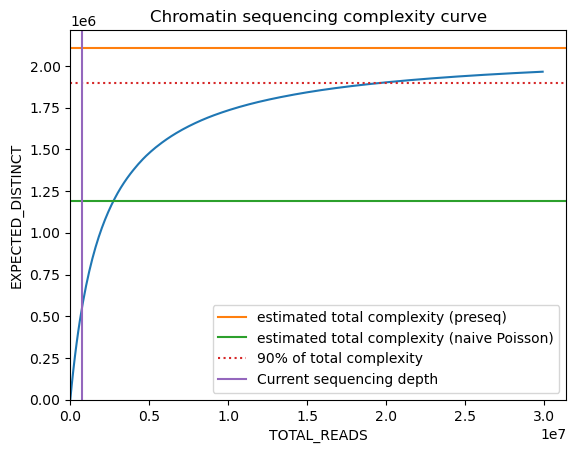

In [32]:
ax = sns.lineplot(
    df_chromatin_complexity_curve,
    x='TOTAL_READS',
    y='EXPECTED_DISTINCT'
)
ax.axhline(
    y=complexity_chromatin_preseq['pop_size_estimate'],
    c='C1',
    label='estimated total complexity (preseq)'
)
ax.axhline(
    y=complexity_chromatin_high,
    c='C2',
    label='estimated total complexity (naive Poisson)'
)
ax.axhline(
    y=0.90*complexity_chromatin_preseq['pop_size_estimate'],
    c='C3',
    ls='dotted',
    label='90% of total complexity'
)
ax.axvline(
    x=df_chromatin['count'].sum(),
    c='C4',
    label='Current sequencing depth'
)
ax.set_title('Chromatin sequencing complexity curve')
ax.set_ylim(0, None)
ax.set_xlim(0, None)
ax.legend()
ax.figure.show()

In [33]:
print('Amount (fold) more sequencing required to achieve 90% coverage:')
df_chromatin_complexity_curve.loc[
    df_chromatin_complexity_curve['EXPECTED_DISTINCT'] >= 0.9 * complexity_chromatin_preseq['pop_size_estimate'],
    'TOTAL_READS'
].min() / df_chromatin['count'].sum()

Amount (fold) more sequencing required to achieve 90% coverage:


25.746181854300136

Coverage estimates

In [34]:
print('Coverage estimate (naive Poisson model): ~{:.1%}'.format(n_chromatin_dedup_start_and_end / complexity_chromatin_high))
# alternatively use n_chromatin_dedup_start_or_end / complexity_chromatin_low, which gives a similar result

print('Coverage estimate (preseq): ~{:.1%}'.format(n_chromatin_dedup_start_and_end / complexity_chromatin_preseq['pop_size_estimate']))

Coverage estimate (naive Poisson model): ~47.4%
Coverage estimate (preseq): ~26.8%


### Chromatin statistics

In [35]:
df_chromatin['length'] = df_chromatin['end'] - df_chromatin['start'] + 1
df_chromatin['species'] = df_chromatin['chr'].str[0].map(dict(h='human', m='mouse')).astype('category')

Number of deduplicated mouse and human chromatin reads is very similar

In [36]:
df_chromatin.groupby('species').size()

species
human    271806
mouse    292759
dtype: int64

Mouse and human chromatin have similar fragmentation sizes, with mouse fragments slightly smaller than human.

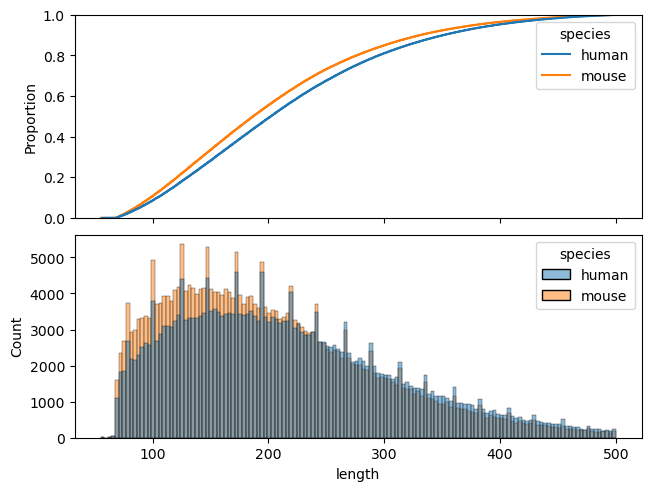

In [37]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=False, constrained_layout=True)
sns.ecdfplot(df_chromatin, x='length', hue='species', ax=axs[0])
sns.histplot(df_chromatin, x='length', hue='species', ax=axs[1])
fig.savefig(os.path.join(DIR_RESULTS, 'chromatin_fragmentation_size.png'), bbox_inches='tight', dpi=300)

The periodic peaks in the histogram for insert size likely corresponds to some barcoding artifact.

\<TODO\>

## Oligo read processing

### Extract UMIs and reformat read names
- splitcode-output read name structure: `@<name>::bead=<#>::[oligo_ID][LigEven] RX:Z:ACCCGTGC`
- Final read name structure = `@<name>::bead=<#>::[oligo_ID]::umi=<umi>`

In [38]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"

PATH_R1="${DIR_PROC}/oligos_R1.fastq.gz"
PATH_R2="${DIR_PROC}/oligos_R2.fastq.gz"
PATH_TMP1="${DIR_PROC}/tmp_R1.fastq.gz"
PATH_TMP2="${DIR_PROC}/tmp_R2.fastq.gz"

splitcode --nFastqs=2 --extract '0:9<umi[8]>' --x-names --no-x-out -t 8 \
    --output="$PATH_TMP1","$PATH_TMP2" \
    "$PATH_R1" "$PATH_R2"

unpigz -c "$PATH_TMP1" |
    sed -E -e 's/(\[LigEven\])? RX:Z:([ATCGN]+)/::umi=\2/' |
    gzip > "$PATH_R1"

unpigz -c "$PATH_TMP2" |
    sed -E -e 's/(\[LigEven\])? RX:Z:([ATCGN]+)/::umi=\2/' |
    gzip > "$PATH_R2"

* Forcing --gzip because all output file names end in .gz
* Using a list of 0 tags (vector size: 0; map size: 0; num elements in map: 0)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data_proc/20240625/oligos_R1.fastq.gz
                         /central/groups/guttman/btyeh/scBarcode/data_proc/20240625/oligos_R2.fastq.gz
* processing the reads ...
done 
* processed 82,998 reads


### Detect cell barcodes from both read 1 and read 2

Read pairs with complete barcodes are separated from read pairs with incomplete barcodes.

In [39]:
path_splitcode_cell_barcode = os.path.join(DIR_AUX, 'splitcode_config-cell_barcode.tsv')

In [40]:
%%bash -s {DIR_PROC} {path_splitcode_cell_barcode}
DIR_PROC="$1"
PATH_CONFIG="$2"

PATH_R1="${DIR_PROC}/oligos_R1.fastq.gz"
PATH_R2="${DIR_PROC}/oligos_R2.fastq.gz"
PATH_MAPPING="${DIR_PROC}/mapping_cell-barcode.tsv"
PATH_SUMMARY="${DIR_PROC}/summary_cell-barcode.json"
PATH_OUT1="${DIR_PROC}/oligos_cell-barcode_R1.fasta.gz"
PATH_OUT2="${DIR_PROC}/oligos_cell-barcode_R2.fasta.gz"
PATH_UNASSIGNED1="${DIR_PROC}/oligos_unassigned_R1.fasta.gz"
PATH_UNASSIGNED2="${DIR_PROC}/oligos_unassigned_R2.fasta.gz"

splitcode -c "$PATH_CONFIG" \
    --nFastqs=2 --com-names --assign --no-outb --x-names --no-x-out --out-fasta -t 8 \
    --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" \
    --output="$PATH_OUT1","$PATH_OUT2" --unassigned="$PATH_UNASSIGNED1","$PATH_UNASSIGNED2" \
    "$PATH_R1" "$PATH_R2"

gzip -f "$PATH_MAPPING"

* Forcing --gzip because all output file names end in .gz
* Using a list of 193 tags (vector size: 193; map size: 31,280; num elements in map: 31,970)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data_proc/20240625/oligos_R1.fastq.gz
                         /central/groups/guttman/btyeh/scBarcode/data_proc/20240625/oligos_R2.fastq.gz
* processing the reads ...
done 
* processed 82,998 reads, 12,768 reads were assigned


For fully-barcoded cell oligos, modify read names so that there is no whitespace between the read name and cell barcode.

In [41]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"

PATH_OUT1="${DIR_PROC}/oligos_cell-barcode_R1.fasta.gz"
PATH_OUT2="${DIR_PROC}/oligos_cell-barcode_R2.fasta.gz"
PATH_TMP="${DIR_PROC}/tmp.fasta.gz"

zcat "$PATH_OUT1" | sed -e 's/ BI:i:/::cell=/' | gzip > "$PATH_TMP"
mv "$PATH_TMP" "$PATH_OUT1"

zcat "$PATH_OUT2" | sed -e 's/ BI:i:/::cell=/' | gzip > "$PATH_TMP"
mv "$PATH_TMP" "$PATH_OUT2"

### Deduplicate and simplify oligos

At this point, we have extracted all possible information from the cell oligos and no longer need the read sequences or even the original read names.

#### Fully barcoded oligos

Simplify the representation of each cell oligo read into the following structure:

`bead=<#>::[human/mouse_<#>]::umi=<umi>::cell=<#>`

This allows for easy deduplication based on bead barcode, cell barcode, and UMI.

In [42]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"

PATH_OUT1="${DIR_PROC}/oligos_cell-barcode_R1.fasta.gz"
PATH_OLIGO_FULL_COUNTS="${DIR_PROC}/oligos_full_barcode_counts.txt"

zcat "$PATH_OUT1" |
    grep -E -o "::bead.*" | 
    sed -E -e 's/^:://' -e 's/ BI:i:/::cell=/' |
    sort |
    uniq -c |
    sed -E -e 's/^ *([^ ]+) +/\1\t/' > "$PATH_OLIGO_FULL_COUNTS"

echo "Number of unique cell oligos:" $(wc -l "$PATH_OLIGO_FULL_COUNTS" | cut -f 1 -d ' ')
echo "Number of unique cells:" $(grep -E -o 'cell=.*' "$PATH_OLIGO_FULL_COUNTS" | sort | uniq | wc -l)
echo "Number of unique beads:" $(grep -E -o '(bead=[0-9]+)' "$PATH_OLIGO_FULL_COUNTS" | sort | uniq | wc -l)

Number of unique cell oligos: 7793
Number of unique cells: 6884
Number of unique beads: 5838


Compare with expected number of cells: 78,000  
Compare with expected number of beads: 1% * 148.15 uL * 2.7e6 beads/uL = 4,000,000 beads

##### Complexity and sequencing saturation estimates

In [43]:
dtype_species = pd.CategoricalDtype(categories=('human', 'mouse'), ordered=True)
dtype_oligo_ID = pd.CategoricalDtype(categories=[f'human_{i}' for i in range(1, 49)] + [f'mouse_{i}' for i in range(1, 49)], ordered=True)

In [44]:
path_oligo_counts = os.path.join(DIR_PROC, 'oligos_full_barcode_counts.txt')
df_oligo_counts = pd.read_csv(path_oligo_counts, sep='\t', names=['count', 'oligo'])

regex_oligo_full_barcode = 'bead=(?P<bead>\d+)::\[(?P<oligo_ID>.*)\]::umi=(?P<umi>[ATCGN]+)::cell=(?P<cell>\d+)'
df_oligo_counts = pd.concat(
    (
        df_oligo_counts.drop(columns='oligo'),
        df_oligo_counts['oligo'].str.extract(regex_oligo_full_barcode)
    ),
    axis=1
).astype({'bead': int, 'cell': 'Int64', 'oligo_ID': dtype_oligo_ID})
df_oligo_counts['species'] = df_oligo_counts['oligo_ID'].str.extract('(mouse|human)').astype(dtype_species)

In [45]:
complexity_oligo_est1 = estimate_library_complexity(df_oligo_counts['count'].sum(), len(df_oligo_counts))
complexity_oligo_est2 = estimate_library_complexity2(df_oligo_counts['count'].sum(), df_oligo_counts['count'].mean())

print('Total reads of fully barcoded cell oligos observed:', df_oligo_counts['count'].sum())
print('Unique fully barcoded cell oligos observed:', len(df_oligo_counts['count']))
print('2 estimates of total unique fully barcoded cell oligos in the aliquot: {:.0f}, {:.0f}'.format(complexity_oligo_est1, complexity_oligo_est2))
print('Estimated fully barcoded cell oligo coverage: {:.2%}'.format(len(df_oligo_counts['count']) / complexity_oligo_est1))

Total reads of fully barcoded cell oligos observed: 12768
Unique fully barcoded cell oligos observed: 7793
2 estimates of total unique fully barcoded cell oligos in the aliquot: 11773, 11773
Estimated fully barcoded cell oligo coverage: 66.19%


Estimate additional reads required to obtain saturation

In [46]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"

source ~/.bashrc
conda activate genomics

PATH_OLIGO_FULL_COUNTS="${DIR_PROC}/oligos_full_barcode_counts.txt"
PATH_OLIGO_FULL_BARCODE_COMPLEXITY_CURVE="${DIR_PROC}/oligos_full_barcode_complexity_curve.tsv"
PATH_OLIGO_FULL_BARCODE_COMPLEXITY_TOTAL="${DIR_PROC}/oligos_full_barcode_complexity_total.tsv"

preseq lc_extrap -o "$PATH_OLIGO_FULL_BARCODE_COMPLEXITY_CURVE" -e 1000000 -s 10000 \
    -V <(cut -f 1 "$PATH_OLIGO_FULL_COUNTS")

preseq pop_size -o "$PATH_OLIGO_FULL_BARCODE_COMPLEXITY_TOTAL" -V <(cut -f 1 "$PATH_OLIGO_FULL_COUNTS")

In [47]:
path_oligo_full_barcode_complexity_curve = os.path.join(DIR_PROC, 'oligos_full_barcode_complexity_curve.tsv')
path_oligo_full_barcode_complexity_total = os.path.join(DIR_PROC, 'oligos_full_barcode_complexity_total.tsv')

df_oligo_full_barcode_complexity_curve = pd.read_csv(path_oligo_full_barcode_complexity_curve, sep='\t', header=0)
oligo_full_barcode_complexity_total = pd.read_csv(path_oligo_full_barcode_complexity_total, sep='\t', header=0).squeeze()

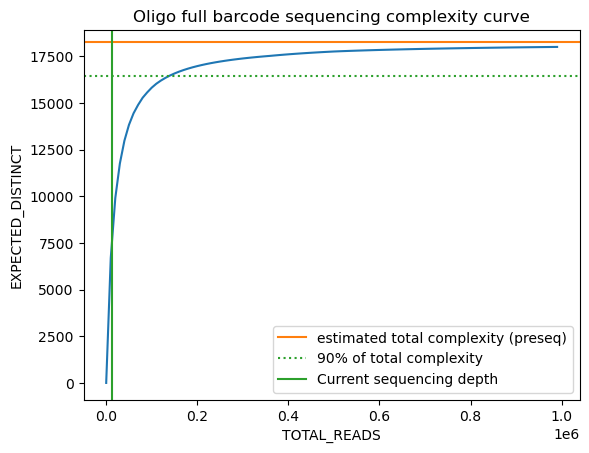

In [48]:
ax = sns.lineplot(
    df_oligo_full_barcode_complexity_curve,
    x='TOTAL_READS',
    y='EXPECTED_DISTINCT'
)
ax.axhline(
    y=oligo_full_barcode_complexity_total['pop_size_estimate'],
    c='C1',
    label='estimated total complexity (preseq)'
)
ax.axhline(
    y=0.90*oligo_full_barcode_complexity_total['pop_size_estimate'],
    c='C2',
    ls='dotted',
    label='90% of total complexity'
)
ax.axvline(
    x=df_oligo_counts['count'].sum(),
    c='C2',
    label='Current sequencing depth'
)
ax.set_title('Oligo full barcode sequencing complexity curve')
ax.legend()
ax.figure.show()

In [49]:
print('Amount (fold) more sequencing required to achieve 90% coverage:')
df_oligo_full_barcode_complexity_curve.loc[
    df_oligo_full_barcode_complexity_curve['EXPECTED_DISTINCT'] >= 0.9 * oligo_full_barcode_complexity_total['pop_size_estimate'],
    'TOTAL_READS'
].min() / df_oligo_counts['count'].sum()

Amount (fold) more sequencing required to achieve 90% coverage:


10.964912280701755

#### Non-fully barcoded oligos

Simplify the representation of each cell oligo read into the following structure:

`bead=<#>::[human/mouse_<#>]::umi=<umi>`

Deduplicate based on bead barcode, species, and UMI.

In [50]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"

PATH_UNASSIGNED1="${DIR_PROC}/oligos_unassigned_R1.fasta.gz"
PATH_OLIGO_PARTIAL_COUNTS="${DIR_PROC}/oligos_partial_barcode_counts.txt"

zcat "$PATH_UNASSIGNED1" |
    grep -E -o "::bead.*" | 
    sed -E -e 's/^:://' |
    sort |
    uniq -c |
    sed -E -e 's/^ *([^ ]+) +/\1\t/' > "$PATH_OLIGO_PARTIAL_COUNTS"

echo "Number of unique cell oligos:" $(wc -l "$PATH_OLIGO_PARTIAL_COUNTS" | cut -f 1 -d ' ')

Number of unique cell oligos: 36656


Probability that UMIs are insufficient to resolve these non-fully-barcoded oligos
- Determine the maximum number of non-fully barcoded oligos per `bead=<#>::[human/mouse_<#>]` class and compare that with the representation space of the 8 bp UMIs.
  - Binomial distribution: $n$ trials = number of reads in a particular `bead=<#>::[human/mouse_<#>]` class, $p$ probability = 1/UMI space.
  - Probability of a collision = 1-CDF(1)
- Result: extremely unlikely for 2 such deduplicated reads to actually originate from the same original oligo --> we assume that the deduplication here is "complete."
- 198 of these partial barcodes may actually be PCR duplicates of a full barcode, where the partial barcode was not detected as a full barcode due to sequencing errors.
  - For beads associated with multiple oligo barcodes (whether partial or full), these partial barcodes may erroneously inflate the perceived number of on-bead collisions.

In [51]:
path_oligo_partial_counts = os.path.join(DIR_PROC, 'oligos_partial_barcode_counts.txt')
df_oligo_partial_counts = pd.read_csv(path_oligo_partial_counts, sep='\t', names=['count', 'oligo'])

regex_oligo_partial_barcode = r'bead=(?P<bead>\d+)::\[(?P<oligo_ID>.*)\]::umi=(?P<umi>[ATCGN]+)'
df_oligo_partial_counts = pd.concat(
    (
        df_oligo_partial_counts.drop(columns='oligo'),
        df_oligo_partial_counts['oligo'].str.extract(regex_oligo_partial_barcode)
    ),
    axis=1
).astype({'bead': int, 'oligo_ID': dtype_oligo_ID})
df_oligo_partial_counts['species'] = df_oligo_partial_counts['oligo_ID'].str.extract('(mouse|human)').astype(dtype_species)

In [52]:
p_collision = 1 - scipy.stats.binom.cdf(
    1,
    df_oligo_partial_counts.groupby(['bead', 'oligo_ID'])['count'].sum().max(),
    1/(4**8)
)
print(
    'Maximum number of non-fully-barcoded oligos sharing a bead and oligo ID:',
    df_oligo_partial_counts.groupby(['bead', 'oligo_ID'])['count'].sum().max()
)
print(
    'Probability that 2 or more of those oligos have the same UMI:',
    p_collision
)

Maximum number of non-fully-barcoded oligos sharing a bead and oligo ID: 173
Probability that 2 or more of those oligos have the same UMI: 3.458034444570046e-06


In [53]:
df_oligo_counts_merged = (
    df_oligo_counts
    .drop(columns='count')
    .merge(
        df_oligo_partial_counts[['bead', 'oligo_ID', 'umi', 'species']],
        how='outer',
        indicator=True
    )
)
sum(df_oligo_counts_merged['_merge'] == 'both')

198

## Oligo-chromatin pairing

In [54]:
class Bead:
    def __init__(self, bead_ID, oligos=None, chromatin=None):
        self.bead_ID = bead_ID
        self.oligos = oligos if oligos is not None else set()
        self.chromatin = chromatin if chromatin is not None else set()
        self.oligo_counts = collections.Counter([(oligo_ID, cell) for (oligo_ID, umi, cell) in self.oligos])
    def add_chromatin(self, chrom, start, end):
        self.chromatin.add((chrom, start, end))
    def add_oligo(self, oligo_ID, umi, cell=pd.NA):
        self.oligos.add((oligo_ID, umi, cell))
        self.oligo_counts[(oligo_ID, cell)] += 1
    def oligo_species_counts(self):
        assert len(self.oligos) == sum(self.oligo_counts.values())
        species_counts = np.zeros(2, dtype=int)
        for oligo_ID, _, _ in self.oligos:
            if oligo_ID.startswith('human'):
                species_counts[0] += 1
            elif oligo_ID.startswith('mouse'):
                species_counts[1] += 1
            else:
                raise ValueError(f'Unexpected oligo_ID {oligo_ID}')
        assert len(self.oligos) == species_counts.sum()
        return {'human': species_counts[0], 'mouse': species_counts[1]}
    def max_prop_oligo_species(self):
        '''
        Return
        - species: str or None
        - count: int
        - proportion: np.float64

        If proportion is 0.5, species is 'human'
        '''
        assert len(self.oligos) == sum(self.oligo_counts.values())
        if len(self.oligos) > 0:
            species_counts = self.oligo_species_counts()
            if species_counts['human'] >= species_counts['mouse']:
                species_main = 'human'
                count = species_counts['human']
            else:
                species_main = 'mouse'
                count = species_counts['mouse']
            return species_main, count, count / sum(species_counts.values())
        else:
            return None, 0, np.nan
    def max_prop_oligo(self):
        '''
        Return
        - oligo: tuple or None
          - oligo_ID: str
          - cell: pd.Int64
        - count: int
        - proportion: np.float64
        '''
        assert len(self.oligos) == sum(self.oligo_counts.values())
        if len(self.oligos) > 0:
            (oligo_ID, cell), count = self.oligo_counts.most_common(1)[0]
            return (oligo_ID, cell), count, count / len(self.oligos)
        else:
            return None, 0, np.nan
    def status(self, species_prop_thresh=0.8, species_min_count=1, oligo_prop_thresh=0.8, oligo_min_count=1):
        '''
        Return
        - (species_main, species_status)
        - (oligo_main, oligo_status)
        '''
        if len(self.oligos) == 0 or len(self.chromatin) == 0:
            return None

        # determine oligo main status
        (oligo_ID, cell), oligo_count, oligo_prop = self.max_prop_oligo()
        if oligo_count == 0:
            oligo_status = 'none'
        elif oligo_count < oligo_min_count:
            oligo_status = 'uncertain'
        elif oligo_prop < oligo_prop_thresh:
            oligo_status = 'ambiguous'
        elif oligo_prop == 1:
            oligo_status = 'unique'
        else:
            oligo_status = 'predominant'

        species, species_count, species_prop = self.max_prop_oligo_species()
        if species_count == 0:
            species_status = 'none'
        elif species_count < species_min_count:
            species_status = 'uncertain'
        elif species_prop < species_prop_thresh:
            species_status = 'ambiguous'
        elif species_prop == 1:
            species_status = 'unique'
        else:
            species_status = 'predominant'

        return (species, species_status), ((oligo_ID, cell), oligo_status)
    def get_chromatin_species_counts(self):
        species_counts = dict(mouse=0, human=0)
        for chrom, _, _ in self.chromatin:
            if chrom.startswith('m_chr'):
                species_counts['mouse'] += 1
            elif chrom.startswith('h_chr'):
                species_counts['human'] += 1
            else:
                raise ValueError(f'Unexpected chromosome name {chrom}')
        return species_counts
    def proper_pairing(self, return_type='status', **kwargs):
        '''
        Returns:
        - If 0 oligos, 0 chromatin, or more than 1 type of chromatin species: None
        - Otherwise: (species_pairing, cell_pairing)
        '''
        if len(self.oligos) == 0:
            if len(self.chromatin) == 0:
                return 'empty bead'
            else:
                return 'no oligos'
        elif len(self.chromatin) == 0:
            return 'no chromatin'

        chromatin_species_counts = self.get_chromatin_species_counts()
        if chromatin_species_counts['mouse'] > 0 and chromatin_species_counts['human'] > 0:
            # contains both human and mouse chromatin --> cannot determine whether bead barcode-cell barcode pairing was specific
            return 'overloaded bead'
        if chromatin_species_counts['mouse'] == 0 and chromatin_species_counts['human'] > 0:
            chromatin_species = 'human'
        elif chromatin_species_counts['mouse'] > 0 and chromatin_species_counts['human'] == 0:
            chromatin_species = 'mouse'
        else:
            # no chromatin - should have returned None prior to this point
            raise RuntimeError

        if return_type == 'status':
            (oligo_species, oligo_species_status), ((oligo_ID, cell), oligo_status) = self.status(**kwargs)
    
            # species pairing
            if chromatin_species == oligo_species:
                species_pairing = oligo_species_status
                # oligo pairing
                if oligo_ID[:5] != chromatin_species:
                    return (species_pairing, 'mixed')
                return (species_pairing, oligo_status)
            else:
                return ('mixed', 'mixed')
        elif return_type == 'counts':
            return (chromatin_species, self.oligo_species_counts())
        else:
            raise ValueError(f'return_type of {return_type} not valid.')

In [55]:
beads = {} # map from bead ID to bead object; uses full and partial oligo barcodes
for _, row in tqdm(df_chromatin.iterrows()):
    if row['bead'] not in beads:
        beads[row['bead']] = Bead(row['bead'], chromatin={(row['chr'], row['start'], row['end'])})
    else:
        beads[row['bead']].add_chromatin(row['chr'], row['start'], row['end'])
beads2 = copy.deepcopy(beads) # same as beads, but uses only full oligo barcdes

for _, row in tqdm(df_oligo_counts_merged.iterrows()):
    if row['bead'] not in beads:
        beads[row['bead']] = Bead(row['bead'], oligos={(row['oligo_ID'], row['umi'], row['cell'])})
    else:
        beads[row['bead']].add_oligo(row['oligo_ID'], row['umi'], row['cell'])

for _, row in tqdm(df_oligo_counts.iterrows()):
    if row['bead'] not in beads2:
        beads2[row['bead']] = Bead(row['bead'], oligos={(row['oligo_ID'], row['umi'], row['cell'])})
    else:
        beads2[row['bead']].add_oligo(row['oligo_ID'], row['umi'], row['cell'])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Specificity

In [56]:
pairing_counts = collections.Counter(bead.proper_pairing() for bead in beads.values())
pairing_counts

Counter({'no oligos': 356866,
         'no chromatin': 27728,
         ('mixed', 'mixed'): 2049,
         ('unique', 'unique'): 1858,
         'overloaded bead': 1800,
         ('unique', 'ambiguous'): 50,
         ('ambiguous', 'ambiguous'): 32,
         ('ambiguous', 'mixed'): 6})

In [57]:
pairing_counts2 = collections.Counter(bead.proper_pairing() for bead in beads2.values())
pairing_counts2

Counter({'no oligos': 361448,
         'no chromatin': 4625,
         'overloaded bead': 474,
         ('mixed', 'mixed'): 382,
         ('unique', 'unique'): 351,
         ('ambiguous', 'ambiguous'): 4,
         ('unique', 'ambiguous'): 2})

Mixing proportion: for beads with only 1 chromatin species, what proportion have cell oligos from a different species?

In [58]:
numerator = sum(count for statuses, count in pairing_counts.items() if (type(statuses) is tuple) and (statuses[0] != 'unique'))
denominator = sum(count for statuses, count in pairing_counts.items() if type(statuses) is tuple)
print(numerator / denominator)

0.5224030037546934


In [59]:
numerator = sum(count for statuses, count in pairing_counts2.items() if (type(statuses) is tuple) and (statuses[0] != 'unique'))
denominator = sum(count for statuses, count in pairing_counts2.items() if type(statuses) is tuple)
print(numerator / denominator)

0.5223274695534507


In [60]:
bead_to_cell_oligo_species = df_oligo_counts_merged.groupby('bead')['species'].agg(lambda x: x.iloc[0] if len(set(x)) == 1 else None).to_dict()

total = 0
mixed = 0
for bead, g in df_chromatin.groupby('bead'):
    if len(g['species'].unique()) == 1 and bead in bead_to_cell_oligo_species:
        chromatin_species = g['species'].iloc[0]
        oligo_species = bead_to_cell_oligo_species[bead]
        if oligo_species is None or oligo_species != chromatin_species:
            mixed += 1
        total += 1
print(mixed, total, mixed / total)

2087 3995 0.5224030037546934


In [65]:
df_mixing_results = []
for bead in beads.values():
    result = bead.proper_pairing(return_type='counts')
    if type(result) is tuple:
        df_mixing_results.append((result[0], result[1]['human'], result[1]['mouse']))
df_mixing_results = pd.DataFrame(df_mixing_results, columns=['bead species', 'human oligo counts', 'mouse oligo counts'])
df_mixing_results = df_mixing_results.groupby(list(df_mixing_results.columns)).size().rename('count').reset_index()

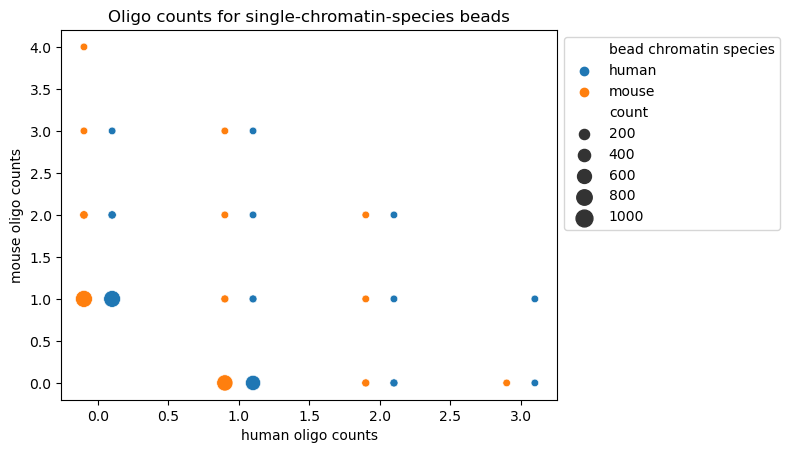

In [67]:
ax = sns.scatterplot(
    # x-jitter human oligo counts for visualization
    df_mixing_results.rename(columns={'bead species': 'bead chromatin species'}) \
        .assign(**{'human oligo counts': df_mixing_results['human oligo counts'] + 0.2 * (df_mixing_results['bead species'] == 'human').astype(float) - 0.1}),
    x='human oligo counts',
    y='mouse oligo counts',
    hue='bead chromatin species',
    size='count',
    sizes=(30, 150)
)
ax.set_title('Oligo counts for single-chromatin-species beads')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.figure.savefig(os.path.join(DIR_RESULTS, 'single-chromatin-species-beads_mixing.png'), bbox_inches='tight', dpi=300)

Proportion of human-chromatin-only beads with only mouse oligos

In [68]:
df_mixing_results.loc[
    (df_mixing_results['bead species'] == 'human') & \
    (df_mixing_results['human oligo counts'] == 0),
    'count'
].sum() / df_mixing_results.loc[
    df_mixing_results['bead species'] == 'human',
    'count'
].sum()

0.5549132947976878

Proportion of mouse-chromatin-only beads with only human oligos

In [69]:
df_mixing_results.loc[
    (df_mixing_results['bead species'] == 'mouse') & \
    (df_mixing_results['mouse oligo counts'] == 0),
    'count'
].sum() / df_mixing_results.loc[
    df_mixing_results['bead species'] == 'mouse',
    'count'
].sum()

0.4555449330783939

# Old

In [ ]:
bead_to_cell_oligo_species_count = df_oligo_counts_merged.groupby('bead')['species'].agg(lambda x: len(set(x))).to_dict()
total = 0
mixed = 0
for bead, g in df_chromatin.groupby('bead'):
    if len(g['species'].unique()) == 1 and bead in bead_to_cell_oligo_species_count:
        if bead_to_cell_oligo_species_count[bead] > 1:
            mixed += 1
        total += 1
print(mixed, total, mixed / total)

### Oligo statistics

Counts of oligos per bead

In [ ]:
path_oligos_R1 = os.path.join(DIR_PROC, 'oligos_R1.fastq.gz')
bead_species_counts = collections.defaultdict(int)
regex_species = re.compile('human|mouse')
with gzip.open(path_oligos_R1, 'rt') as f:
    for name, _, _, _ in tqdm(fastq_parse(f)):
        bead = int(regex_bead.search(name).groups()[0])
        species = regex_species.search(name).group()
        bead_species_counts[(bead, species)] += 1

In [ ]:
df_bead_oligo_species = pd.Series(bead_species_counts).rename('count').reset_index().rename(columns=dict(level_0='bead', level_1='species'))

In [ ]:
df_bead_oligo_species.groupby('bead')['count'].sum().sort_values(ascending=False).head(10)

In [ ]:
tmp = df_bead_oligo_species.groupby('bead').agg(**{
    'max_proportion': pd.NamedAgg(column='count', aggfunc=lambda x: max(x / x.sum())),
    'total_count': pd.NamedAgg(column='count', aggfunc='sum')})

In [ ]:
ax = sns.scatterplot(
    tmp.loc[(tmp['total_count'] > 2) & (tmp['total_count'] < 20)],
    x='total_count',
    y='max_proportion'
)

# Todo

Re-check all code

Check CTCF ChIP tracks
- extract species-specific track, compare against ENCODE or other references
- peak calling / motif finding